In [1]:
%load_ext autoreload
%autoreload 2
# when debugging the python scripts, with the autoreload the jupyter notebook sync's to the most up to date scripts. See: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import sklearn.model_selection as skm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, fbeta_score, make_scorer, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import random
from tqdm import tqdm
from dataprep import *
import anndata as ad
import pickle

/media/gambino/students_workdir/nynke/miniconda3/envs/blurry/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 101
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
rng = np.random.RandomState(seed)

## Loading RF Models & Datasets

Paths to pericellular/other patterns RF models

In [20]:
path1 = "/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_balanced/rf_pericellular.pkl"
with open(path1, 'rb') as p:
    rf_pericellular_splitID_balanced = pickle.load(p)

# The plots from the ppt are from this unbalanced model, didn't have the time to make a balanced version yet.
path2 = "/media/gambino/students_workdir/nynke/blurry/temp_objects/incl_random/rf_pericellular.pkl"
with open(path2, 'rb') as p:
    rf_pericellular_inclRandom_splitID_unbalanced = pickle.load(p)


path3 = "/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_balanced/rf_pericellular_balanced_mixedIDs.pkl"
with open(path3, 'rb') as p:
    rf_pericellular_mixedID_balanced = pickle.load(p)

In [3]:
path = f"/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_balanced/rf_pattern.pkl"
with open(path, 'rb') as p:
    rf_pattern_balanced = pickle.load(p)

Here's the paths to load the pattern/no pattern RF (balanced & unbalanced) in case you would like them:

path = f"/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_balanced/rf_pattern.pkl"
with open(path, 'rb') as p:
    rf_pattern_balanced = pickle.load(p)

path = f"/media/gambino/students_workdir/nynke/blurry/temp_objects/rf_pattern_noPattern.pkl"
with open(path, 'rb') as p:
    rf_pattern_unbalanced = pickle.load(p)

In [4]:
#adata_all_spots = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/all_spots_simulated_embeddings_adata.h5ad")
adata_split_cellID = sc.read_h5ad("/media/gambino/students_workdir/nynke/new_model_with_cell_id_left_out_custom_nynke_panel_simulated_embeddings_adata.h5ad")
#adata_mixed_cellID = sc.read_h5ad("/media/gambino/students_workdir/nynke/data/custom_nynke_panel_simulated_embeddings_adata.h5ad")

In [5]:
# Add an extra column to the adata.obs dataframe that contains the pattern strength, given that protrusion has different pattern strength levels than the other patterns.
choices = ['strong', 'intermediate', 'low']
for adata in [adata_split_cellID]:#, adata_mixed_cellID, adata_all_spots]:
    conditions = [
        (adata.obs['prop'] == 0.9) | ((adata.obs['prop'] == 0.4) & (adata.obs['pattern'] == 'protrusion')),
        (adata.obs['prop'] == 0.5) | ((adata.obs['prop'] == 0.2) & (adata.obs['pattern'] == 'protrusion')),
        (adata.obs['prop'] == 0.1) | ((adata.obs['prop'] == 0.0) & (adata.obs['pattern'] == 'protrusion'))
    ]

    adata.obs['pattern_strength'] = np.select(conditions, choices, default='unknown')

In [24]:
# Creating the simulated genes (1 gene ~300 cells). Method can be found in dataprep.py
# In this case, the genes contain all the counts, iso only low counts. 
pericellular_dict_all = subsetGenes(adata_all_spots, 'pericellular', pattern_strength = "strong", mixed_counts = True)
peri_dict_mixed_cellID = subsetGenes(adata_mixed_cellID, 'pericellular', pattern_strength = "strong", mixed_counts = True)
pericellular_dict_split_cellID = subsetGenes(adata_split_cellID, 'pericellular', pattern_strength = "strong", mixed_counts = True)
pericellular_dict_split_testID = subsetGenes(adata_split_cellID[adata_split_cellID.obs['cell_id'].isin(adata_split_cellID.uns['test_cellIDs'])], 'pericellular', pattern_strength = "strong", mixed_counts = True)

In [6]:
adata_test = adata_split_cellID[adata_split_cellID.obs['cell_id'].isin(adata_split_cellID.uns['test_cellIDs'])]

pericellular_dict_low = subsetGenes(adata_test, 'pericellular', pattern_strength = "strong", count_threshold = 11, high_or_low = 'low')
random_dict_low = subsetGenes(adata_test, 'random', count_threshold = 11, high_or_low = 'low', mixed_counts=False)

In [11]:
pericellular_dict_low

{0: AnnData object with n_obs × n_vars = 52 × 15
     obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths', 'pattern_strength'
     obsm: 'latent',
 1: AnnData object with n_obs × n_vars = 52 × 15
     obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths', 'pattern_strength'
     obsm: 'latent',
 2: AnnData object with n_obs × n_vars = 52 × 15
     obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths', 'pattern_strength'
     obsm: 'latent',
 3: AnnData object with n_obs × n_vars = 52 × 15
     obs: 'pattern

In [21]:
adata_test.obs['n_spots_interval'].value_counts()

100+      135948
10-20      23033
40-50      22732
50-60      22670
30-40      22644
90-100     22507
80-90      22279
20-30      22113
70-80      22073
0-10       13350
Name: n_spots_interval, dtype: int64

In [ ]:
# Creating the simulated genes (1 gene ~300 cells). Method can be found in dataprep.py
# In this case, the genes contain all the counts, iso only low counts. 
adata, pattern: str = 'pericellular', mixed_patterns: bool = False, pattern_strength: str = "strong", count_threshold: int = 11, high_or_low: str = 'low', mixed_counts: bool = False, random_seed: int = 101
pericellular_dict_all = subsetGenes(adata_all_spots, 'pericellular', pattern_strength = "strong", mixed_counts = True)
peri_dict_mixed_cellID = subsetGenes(adata_mixed_cellID, 'pericellular', pattern_strength = "strong", mixed_counts = True)
pericellular_dict_split_cellID = subsetGenes(adata_split_cellID, 'pericellular', pattern_strength = "strong", mixed_counts = True)
pericellular_dict_split_testID = subsetGenes(adata_split_cellID[adata_split_cellID.obs['cell_id'].isin(adata_split_cellID.uns['test_cellIDs'])], 'pericellular', pattern_strength = "strong", mixed_counts = True)

In [7]:
adata_test = adata_split_cellID[adata_split_cellID.obs['cell_id'].isin(adata_split_cellID.uns['test_cellIDs'])]

pericellular_dict_low_strong = subsetGenes(adata_test, 'pericellular', pattern_strength = "strong", count_threshold = 11, high_or_low = 'low')
pericellular_dict_low_mid = subsetGenes(adata_test, 'pericellular', pattern_strength="intermediate", count_threshold = 11, high_or_low = 'low')
pattern_dict_low_strong = subsetGenes(adata_test, mixed_patterns = True, pattern_strength = "strong", count_threshold = 11, high_or_low = 'low')
pattern_dict_low_mid = subsetGenes(adata_test, mixed_patterns = True, pattern_strength = "intermediate", count_threshold = 11, high_or_low = 'low')

In [ ]:
rows = []
gene_id = np.array(range(10))


for i in range(10):
    pericellular_strong = rf_pattern_balanced.predict_proba(pericellular_dict_low.get(i).obsm["latent"])[:,1]
    random_low = rf_pattern_balanced.predict_proba(random_dict_low.get(i).obsm["latent"])[:,1]
    for value in pericellular_strong:
        rows.append({'prob_pattern': value, 'group': 'pericellular_strong', 'gene_id': i})
    for value in random_low:
        rows.append({'prob_pattern': value, 'group': 'random_low', 'gene_id': i})
df = pd.DataFrame(rows)

# KS test over multiple gene_ids. 
pattern = df[(df['group']=='pattern_low') & (df['gene_id']==0)]
control = df[(df['group']=='pattern_low') & (df['gene_id']==1)]

# Perform two-sample KS test
statistic, pvalue = ks_2samp(pattern['prob_pattern'], control['prob_pattern'])
print('Test statistic:', statistic)
print('P-value:', pvalue)

In [10]:
random_dict_low = subsetGenes(adata_test, 'random', count_threshold = 11, high_or_low = 'low', mixed_counts=False)
random_dict_high = subsetGenes(adata_test, 'random', count_threshold = 100, high_or_low = 'high', mixed_counts=False)

# Generating the Histograms

Based on the Dictionaries created above, this code snippet creates a dataframe with the RF classification probabilities of the different models for the different datasets. The histograms below include 10 of these genes, hence the range(10). 

Predict_proba returns a nx2 array, where the two columns are the probabilities for [other pattern, pattern], hence the [:,1]

In [58]:
rows = []
gene_id = np.array(range(10))


for i in range(10):
    pericellular_strong = rf_pattern_balanced.predict_proba(pericellular_dict_low_strong.get(i).obsm["latent"])[:,1]
    pericellular_mid = rf_pattern_balanced.predict_proba(pericellular_dict_low_mid.get(i).obsm["latent"])[:,1]
    random_low = rf_pattern_balanced.predict_proba(random_dict_low.get(i).obsm["latent"])[:,1]
    random_high = rf_pattern_balanced.predict_proba(random_dict_high.get(i).obsm["latent"])[:,1]
    pattern_strong = rf_pattern_balanced.predict_proba(pattern_dict_low_strong.get(i).obsm["latent"])[:,1]
    pattern_mid = rf_pattern_balanced.predict_proba(pattern_dict_low_mid.get(i).obsm["latent"])[:,1]
    for value in pericellular_strong:
        rows.append({'prob_pattern': value, 'group': 'pericellular_strong', 'gene_id': i})
    for value in pericellular_mid: 
        rows.append({'prob_pattern': value, 'group': 'pericellular_mid', 'gene_id': i})
    for value in random_low:
        rows.append({'prob_pattern': value, 'group': 'random_low', 'gene_id': i})
    for value in random_high:
        rows.append({'prob_pattern': value, 'group': 'random_high', 'gene_id': i})
    for value in pattern_strong:
        rows.append({'prob_pattern': value, 'group': 'pattern_strong', 'gene_id': i})
    for value in pattern_mid:
        rows.append({'prob_pattern': value, 'group': 'pattern_mid', 'gene_id': i})
df = pd.DataFrame(rows)

Code below generates the histograms. You can easily change the model and dataset shown in the plot by changing the numbers in the third line.

all spots
custom panel, mixed cellID
custom panel, split cellID, test+train
custom panel, split cellID, test only

In [34]:
pattern_dict_low_strong.get(0)

AnnData object with n_obs × n_vars = 64 × 15
    obs: 'pattern', 'random_or_pattern', 'n_spots', 'n_spots_interval', 'cell_id', 'genes', 'rotation', 'rotation_interval', 'blur', 'prop', 'prop_interval', 'corresponding_dapis', 'train_or_val', 'original_image_paths', 'pattern_strength'
    uns: 'test_cellIDs', 'train_cellIDs'
    obsm: 'latent'

In [36]:
df[(df['group']=='pattern_strong')&(df['gene_id']==0)]

,prob_pattern,group,gene_id
227,0.975,pattern_strong,0
228,0.450,pattern_strong,0
229,0.940,pattern_strong,0
230,0.665,pattern_strong,0
231,0.805,pattern_strong,0
...,...,...,...
286,0.975,pattern_strong,0
287,0.995,pattern_strong,0
288,0.860,pattern_strong,0
289,0.765,pattern_strong,0


In [46]:
pattern_dict_low_strong.get(0).obs['pattern'].values

['cell-edge', 'cell-edge', 'cell-edge', 'cell-edge', 'cell-edge', ..., 'protrusion', 'protrusion', 'protrusion', 'protrusion', 'protrusion']
Length: 64
Categories (8, object): ['cell-edge', 'extranuclear', 'foci', 'intranuclear', 'nuclear-edge', 'pericellular', 'perinuclear', 'protrusion']

In [67]:
df_all=pd.DataFrame()
for i in range(10):
    patterns = pattern_dict_low_strong.get(i).obs['pattern'].values

    # Assuming pattern_low['prob_pattern'] is your data
    pattern_low = df[(df['group']=='pattern_strong')&(df['gene_id']==i)]
    data = pattern_low['prob_pattern']
    df_new = pd.DataFrame({'data': data, 'pattern': patterns})
    df_all = pd.concat([df_all,df_new],axis=0)
df_all

,data,pattern
227,0.975,cell-edge
228,0.450,cell-edge
229,0.940,cell-edge
230,0.665,cell-edge
231,0.805,cell-edge
...,...,...
3280,0.155,perinuclear
3281,0.625,perinuclear
3282,0.990,protrusion
3283,0.995,protrusion


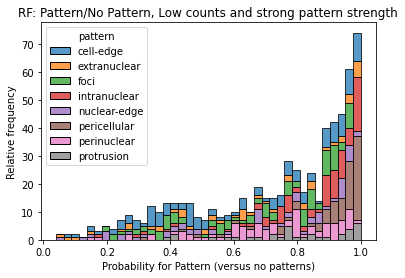

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
df_all=pd.DataFrame()
for i in range(10):
    patterns = pattern_dict_low_strong.get(i).obs['pattern'].values

    # Assuming pattern_low['prob_pattern'] is your data
    pattern_low = df[(df['group']=='pattern_strong')&(df['gene_id']==i)]
    data = pattern_low['prob_pattern']
    df_new = pd.DataFrame({'data': data, 'pattern': patterns})
    df_all = pd.concat([df_all,df_new],axis=0)

# Create the histogram
sns.histplot(data=df_all, x='data', hue='pattern', bins=40, multiple='stack')

plt.title(f"RF: Pattern/No Pattern, Low counts and {type} pattern strength")
plt.xlabel("Probability for Pattern (versus no patterns)")
plt.ylabel("Relative frequency")
plt.show()

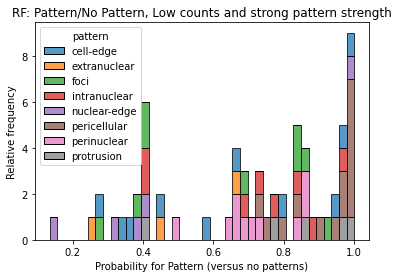

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt

patterns = pattern_dict_low_strong.get(0).obs['pattern'].values

# Assuming pattern_low['prob_pattern'] is your data
pattern_low = df[(df['group']=='pattern_strong')&(df['gene_id']==0)]
data = pattern_low['prob_pattern']
df_new = pd.DataFrame({'data': data})
df_new['pattern']= patterns

# Create the histogram
sns.histplot(data=df_new, x='data', hue='pattern', bins=40, multiple='stack')

plt.title(f"RF: Pattern/No Pattern, Low counts and {type} pattern strength")
plt.xlabel("Probability for Pattern (versus no patterns)")
plt.ylabel("Relative frequency")
plt.show()

54
48
31


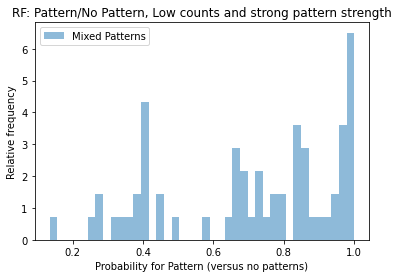

In [21]:
groups = ['pericellular_low','random_low','pattern_low','pericellular_high', 'random_high', 'pattern_high']
type = 'strong'
if type == 'strong':
    pericellular = df[(df['group']=='pericellular_strong')&(df['gene_id']==0)]
    pattern_low = df[(df['group']=='pattern_strong')&(df['gene_id']==0)]
    random_low = df[(df['group']=='random_low')&(df['gene_id']==0)]
if type == 'intermediate':
    pericellular = df[(df['group']=='pericellular_mid')&(df['gene_id']==0)]
    pattern_low = df[(df['group']=='pattern_mid')&(df['gene_id']==3)]
    random_low = df[(df['group']=='random_low')&(df['gene_id']==3)]
print(len(random_low['prob_pattern'].unique()))
print(len(pattern_low['prob_pattern'].unique()))
print(len(pericellular['prob_pattern'].unique()))
#plt.hist(random_low['prob_pattern'], bins=30, alpha=0.4, label='Random', density=True)
#plt.hist(pericellular['prob_pattern'], bins=30, alpha=0.4, label='Pericellular', density=True)
plt.hist(pattern_low['prob_pattern'], bins=40, alpha=0.5, label='Mixed Patterns', density=True)


plt.title(f"RF: Pattern/No Pattern, Low counts and {type} pattern strength")
plt.legend(loc='upper left')
plt.xlabel("Probability for Pattern (versus no patterns)")
plt.ylabel("Relative frequency")
plt.show()

In [10]:
rows = []
gene_id = np.array(range(10))


for i in range(10):
    pericellular_strong = rf_pattern_balanced.predict_proba(pericellular_dict_low.get(i).obsm["latent"])[:,1]
    random_low = rf_pattern_balanced.predict_proba(random_dict_low.get(i).obsm["latent"])[:,1]
    for value in pericellular_strong:
        rows.append({'prob_pattern': value, 'group': 'pericellular_strong', 'gene_id': i})
    for value in random_low:
        rows.append({'prob_pattern': value, 'group': 'random_low', 'gene_id': i})
df = pd.DataFrame(rows)

In [14]:
from scipy.stats import ks_2samp
import numpy as np

In [25]:
# KS test over multiple gene_ids. 
pattern = df[(df['group']=='pericellular_strong') & (df['gene_id']==0)]
control = df[(df['group']=='random_low') & (df['gene_id']==0)]

# Perform two-sample KS test
statistic, pvalue = ks_2samp(pattern['prob_pattern'], control['prob_pattern'])
print('Test statistic:', statistic)
print('P-value:', pvalue)

Test statistic: 0.8137019230769231
P-value: 0.0


In [28]:
test = []
for test_id in range(10):
    for control_id in range(10):
        pattern = df[(df['group']=='pericellular_strong') & (df['gene_id']==test_id)]
        control = df[(df['group']=='random_low') & (df['gene_id']==control_id)]
        statistic, pvalue = ks_2samp(pattern['prob_pattern'], control['prob_pattern'])
        test.append(pvalue)
print(test)

[0.0, 0.0, 0.0, 0.0, 0.0, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.1094237467877974e-15, 0.0, 0.0, 0.0, 0.0, 6.661338147750939e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 4.218847493575595e-15, 0.0, 0.0, 0.0, 0.0, 6.661338147750939e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 4.218847493575595e-15, 0.0, 0.0, 0.0, 0.0, 1.5543122344752192e-15, 2.220446049250313e-16, 2.1094237467877974e-15, 2.220446049250313e-16, 2.220446049250313e-16, 2.7644553313166398e-14, 0.0, 0.0, 0.0, 0.0, 0.0, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 2.220446049250313e-16, 4.218847493575595e-15, 1.2472245458639009e-12, 1.2472245458639009e-12, 4.8978598954363406e-12, 1.2472245458639009e-12, 1.3924028596790095e-10, 2.058742065713659e-11, 1.0043010867377689e-10, 2.058742065713659e-11, 7.482126029856317e-12, 6.525717743954829e-10, 4.107

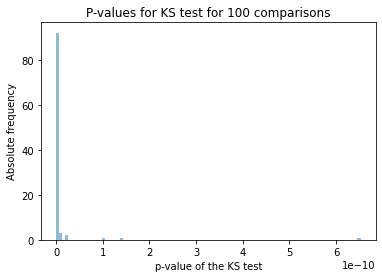

In [34]:

plt.hist(test, bins=len(test), alpha=0.5, density=False)


plt.title("P-values for KS test for 100 comparisons")
plt.xlabel("p-value of the KS test")
plt.ylabel("Absolute frequency")
plt.show()

In [13]:
# KS test over multiple gene_ids. 
pattern = df[(df['group']=='pattern_low') & (df['gene_id']==0)]
control = df[(df['group']=='random_low') & (df['gene_id']==1)]

# Perform two-sample KS test
statistic, pvalue = ks_2samp(pattern['prob_pattern'], control['prob_pattern'])
print('Test statistic:', statistic)
print('P-value:', pvalue)

NameError: name 'ks_2samp' is not defined

### Is there a difference between intermediate low genes?

In [96]:
group = 'random_low'
test = df[(df['group']==group)]

samples = {i: test[test['gene_id'] == i] for i in range(10)}

In [88]:
from scipy import stats

In [97]:
stats.kruskal(*[samples[i]['prob_pattern'] for i in range(10)])

KruskalResult(statistic=9.648449604422133, pvalue=0.37968731671730993)

# Code I used to generate the RF in case you're interested

## Preprocessing data

In [6]:
# Decided to use "no pattern" iso "random" for pattern versus no pattern classifier. 
adata_split_cellID.obs['random_or_pattern'] = adata_split_cellID.obs['random_or_pattern'].replace('random','no_pattern')
adata_split_cellID.obs['pattern'] = adata_split_cellID.obs['pattern'].replace('random','no_pattern')

In [7]:
adata_strong = adata_split_cellID[adata_split_cellID.obs['pattern_strength']=='strong']

adata_train = adata_strong[adata_strong.obs['cell_id'].isin(adata_strong.uns['train_cellIDs'])]
adata_test = adata_strong[adata_strong.obs['cell_id'].isin(adata_strong.uns['test_cellIDs'])]

### Pattern / No pattern RF

In [17]:
# Balancing the training sets. 
adata_train_balanced = balanceTrainingData_pattern_noPattern(adata_train, random_seed=seed)
adata_test_balanced = balanceTrainingData_pattern_noPattern(adata_test, random_seed=seed)

I did hyperparameter tuning, and the best parameters I got were with `max_features=3` and `n_estimators=200`. 
Can share that if you want, but don't think it is very relevant here.

In [16]:
# create random forest classifier and fit on training data
rf_classifier_balanced = RandomForestClassifier(n_estimators=200, random_state=seed, max_features=3, bootstrap=True, oob_score=False, n_jobs = 4)
rf_classifier_balanced.fit(adata_train_balanced.obsm["latent"], adata_train_balanced.obs["random_or_pattern"]) #first test on pattern/no pattern. Then will select the pattern and cluster that again. 

RandomForestClassifier(max_features=3, n_estimators=200, n_jobs=4,
                       random_state=101)

### RF: Pericellular versus other patterns 

In [8]:
# Add column to data to use for binary classifiers RF, eg. "pericellular" or "other". 
# Then balance the training and test set for the binary pattern/other patterns classifier.

patterns = adata_train.obs['pattern'].unique()
train_data = {}
test_data = {}

for pattern in patterns:
    adata_train.obs[pattern] = np.where(adata_train.obs["pattern"] == pattern, pattern, "other")
    adata_test.obs[pattern] = np.where(adata_test.obs["pattern"] == pattern, pattern, "other")
    train_data[pattern] = balanceTrainingData(adata_train, testPattern = pattern, include_random = True, random_seed = seed)
    test_data[pattern] = balanceTrainingData(adata_test, testPattern = pattern, include_random = True, random_seed = seed)


<ipython-input-8-32635b48a1e9>:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_train.obs[pattern] = np.where(adata_train.obs["pattern"] == pattern, pattern, "other")
<ipython-input-8-32635b48a1e9>:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_test.obs[pattern] = np.where(adata_test.obs["pattern"] == pattern, pattern, "other")


f1 score:  0.9642644194458798
inverted f1 score:  0.9650561666731449
auc:  0.9955395416398474


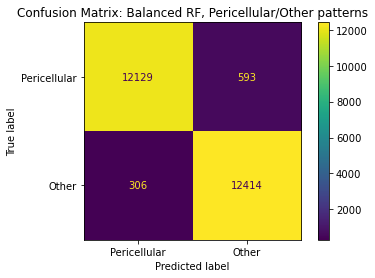

In [9]:
 # create random forest classifier Pericellular/Other patterns EXCLUDING random
rf_pericellular_splitID_random_balanced = RandomForestClassifier(n_estimators=200, random_state=seed, max_features=3, bootstrap=True, oob_score=False, n_jobs = 4)
rf_pericellular_splitID_random_balanced.fit(train_data['pericellular'].obsm["latent"], train_data['pericellular'].obs["pericellular"]) 
    
#predict label
test_pericellular = rf_pericellular_splitID_random_balanced.predict(test_data['pericellular'].obsm["latent"]) # for f1 & confusion matrix
test_peri = rf_pericellular_splitID_random_balanced.predict_proba(test_data['pericellular'].obsm["latent"]) # for auc


print("f1 score: ", f1_score(test_data['pericellular'].obs["pericellular"], test_pericellular, pos_label='pericellular'))
print("inverted f1 score: ", f1_score(test_data['pericellular'].obs["pericellular"], test_pericellular, pos_label='other'))
print("auc: ", roc_auc_score(test_data['pericellular'].obs["pericellular"], test_peri[:,1]))


confusion_matrix = metrics.confusion_matrix(test_data['pericellular'].obs["pericellular"], test_pericellular, labels = ["pericellular","other"])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Pericellular", "Other"]) 
cm_display.plot()
plt.title("Confusion Matrix: Balanced RF, Pericellular/Other patterns")
plt.show()

In [10]:
import pickle



path = f"temp_objects/rf_balanced/rf_pericellular_balanced_inclRandom.pkl"

# Open the file in write-binary mode and dump the object
with open(path, 'wb') as f:
    pickle.dump(rf_pericellular_splitID_random_balanced, f)

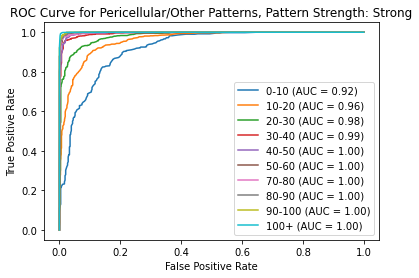

In [11]:
adata_test_peri_balanced = test_data['pericellular']
intervals = ['0-10','10-20','20-30', '30-40','40-50', '50-60', '70-80','80-90', '90-100', '100+']
predictions = {}

fig, ax = plt.subplots()

for interval in intervals:
    adata_counts = adata_test_peri_balanced[adata_test_peri_balanced.obs['n_spots_interval']==interval]
    test_pred = rf_pericellular_splitID_random_balanced.predict_proba(adata_counts.obsm["latent"])[:,1]
    predictions[interval] = RocCurveDisplay.from_predictions(
        adata_counts.obs['pericellular'],
        test_pred, 
        pos_label = "pericellular",
        name = interval,
        ax=ax)
_ = ax.set(xlabel = "False Positive Rate",
    ylabel = "True Positive Rate",
    title = "ROC Curve for Pericellular/Other Patterns, Pattern Strength: Strong")
ax.plot(np.arange(0,1,5),np.arange(0,1,5))

plt.legend(loc='lower right')
plt.show()

## Load data to visualize the different pattern strengths

In [14]:
adata_test = adata_split_cellID[adata_split_cellID.obs['cell_id'].isin(adata_split_cellID.uns['test_cellIDs'])]

In [16]:
patterns = adata_train[adata_train.obs['pattern']!='random'].obs['pattern'].unique()
test_data_inclRandom = {}
test_data_exclRandom = {}

for pattern in patterns:
    adata_test.obs[pattern] = np.where(adata_test.obs["pattern"] == pattern, pattern, "other")
    test_data_inclRandom[pattern] = balanceTrainingData(adata_test, testPattern = pattern, include_random = False, random_seed = seed)
    test_data_exclRandom[pattern] = balanceTrainingData(adata_test, testPattern = pattern, include_random = True, random_seed = seed)

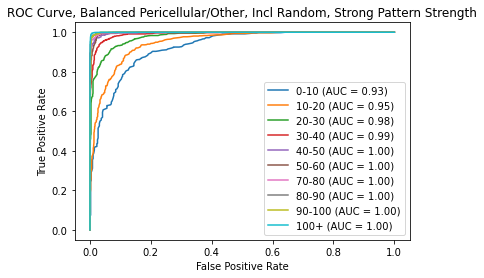

In [19]:
test_peri = test_data_inclRandom['pericellular']
adata_test_strength = test_peri[test_peri.obs["pattern_strength"]=="strong"]
intervals = ['0-10','10-20','20-30', '30-40','40-50', '50-60', '70-80','80-90', '90-100', '100+']
predictions = {}

fig, ax = plt.subplots()

for interval in intervals:
    adata_counts = adata_test_strength[adata_test_strength.obs['n_spots_interval']==interval]
    test_pred = rf_pericellular_splitID_random_balanced.predict_proba(adata_counts.obsm["latent"])[:,1]
    predictions[interval] = RocCurveDisplay.from_predictions(
        adata_counts.obs['pericellular'],
        test_pred, 
        pos_label = "pericellular",
        name = interval,
        ax=ax)
_ = ax.set(xlabel = "False Positive Rate",
    ylabel = "True Positive Rate",
    title = "ROC Curve, Balanced Pericellular/Other, Incl Random, Strong Pattern Strength")


plt.legend(loc='lower right')
plt.show()
#adata_test_balanced.obs['n_spots_interval'].value_counts()

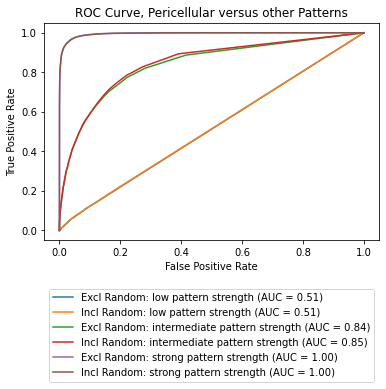

In [23]:
test_peri = test_data_inclRandom['pericellular']
pattern_strength = ["low", "intermediate", "strong"]

models= {"Excl Random: ": rf_pericellular_splitID_balanced,"Incl Random: ": rf_pericellular_splitID_random_balanced}
predictions = {}

fig, ax = plt.subplots()

for strength in pattern_strength:
    for name, model in models.items():
        adata_test_strength = test_peri[test_peri.obs["pattern_strength"]==strength]
        test_pred = model.predict_proba(adata_test_strength.obsm["latent"])[:,1]
        predictions[name] = RocCurveDisplay.from_predictions(
            adata_test_strength.obs['pericellular'],
            test_pred, 
            pos_label = "pericellular",
            name = f"{name}{strength} pattern strength",
            ax=ax)
_ = ax.set(xlabel = "False Positive Rate",
    ylabel = "True Positive Rate",
    title = "ROC Curve, Pericellular versus other Patterns"
    )

plt.legend(bbox_to_anchor=(0, -0.4, 1,0.2), loc="upper center")
plt.show()
#adata_test_balanced.obs['n_spots_interval'].value_counts()